Convert this talk to a HTML preserntation via  
`jupyter nbconvert talk.ipynb --to slides`

https://medium.com/@mjspeck/presenting-code-using-jupyter-notebook-slides-a8a3c3b59d67

In [1]:
# Import packages, prepare data
# (TODO paste the file in here later again. I just don't like scrolling all the time while drafting this notebook)

%run setup.py

![title](img/title.jpg)

- <img src="img/twitter.svg" style="height: 20px; float: left" /> &nbsp; @eng_elhardt
- <img src="img/github.svg" style="height: 20px; float: left" /> &nbsp; AlexEngelhardt (slides: https://github.com/AlexEngelhardt/iml-talk)
- Longer blog post available at https://www.alpha-epsilon.de/blog/

## Outline

TODO das out of date already :D

- Intro
- What is interpretable machine learning?
- Why we need interpretability
- How to achieve interpretability
  - 1: Use interpretable models
  - 2: Post-hoc model-agnostic methods
- Model-agnostic methods
  - Taxonomy
  - Permutation Feature Importance
  - Partial Dependence Plots
  - LIME
- Topics not covered
- The future of IML

# Intro: Problems in ML models

### Problem 1: Fairness

Story source: https://appsilon.com/please-explain-black-box/

- In October 2018 world headlines reported about [Amazon AI recruiting tool](https://www.theguardian.com/technology/2018/oct/10/amazon-hiring-ai-gender-bias-recruiting-engine) that favored men. Amazon’s model was trained on biased data that were skewed towards male candidates. It has built rules that penalized resumes that included the word “women’s”.
- Solution: PFI

### Problem 2: Understanding

- Many of us ultimately want to use datasets to extract scientific knowledge. A 98% accurate Random Forest is no good if we can't extract an explanation from the model.
- Scientific disciplines (e.g biology) use more and more ML. Their ultimate goal is not a correct model, but *knowledge*. IML extracts knowledge from a trained model.
- TODO read https://arxiv.org/pdf/1905.08883.pdf and Doshi-Velez 2017
- Solution: PDPs

### Problem 3: Explainability

- In February 2019 the Polish government added an amendment to a banking law that gives a customer a right to receive an explanation in case of a negative credit decision. It’s one of the direct consequences of implementing GDPR in EU. This means that a bank needs to be able to explain why the loan wasn’t granted if the decision process was automatic.
- The EU's GDPR states: "[the data subject should have] the right ... to obtain an explanation of the decision reached". 
- Solution: Local method. Shapley Values or SHAP or LIME or Counterfactual Examples


# Debugging ML models


- Debugging and auditing (why does my model misclassify all <18 year olds?) is only possible when a model can be interpreted. An interpretation for a wrong prediction helps to understand the cause of the error and point you to what kind of additional training data you'll need.  Knowing *why* a model made a decision helps you to learn more about the problem, the data, and the reason why a model might fail.
  - Also, if you understand your model well, you're better equipped for feature engineering, or even deciding to replace your model with a different one.

<img src="img/husky-vs-wolf-LIME-paper.png" style="height: 200px" />

- Solution: Get more pictures from Huskys in Alaska

# Lesson

- Lesson: The need emerges to be able to look under the hood of machine learning models and *understand* their behavior.
- This talk aims to be an introduction into the field and its methods.
- Because our loss function is often just a bad proxy for what we really want to optimize¹. Additional criteria that are not covered by the loss function:
  - fairness, explainability (as mentioned before),
    - This might also increase social acceptance of AI models
  - but also safety: You want to be 100% certain the abstraction for "cyclist" a DL driving model learned is correct. Imagine the model learned to "see" two wheels, then you'd run over bikes with side bags.
- These criteria often cannot be quantified. E.g. we can't enumerate and write all unit tests required to let an autonomous car drive completely safely.
- Interpretability is a popular fallback: If the system can /explain/ its reasoning, we can verify whether that reasoning makes sense with respect to these auxiliary criteria.
    
¹ Doshi-Velez et al., 2017

# Interpretable Machine Learning (IML) / Explainable AI (XAI)

<img src="img/iml-book.jpg" style="height: 200px" />

> "Interpretability is the degree to which a human can understand the cause of a decision"
>
> -- Miller, Tim. "Explanation in artificial intelligence: Insights from the social sciences." [arXiv:1706.07269](https://arxiv.org/abs/1706.07269)

- A relatively young field, changes quickly, research papers at high speed
- This talk is based on Christoph Molnar: Interpretable Machine Learning
  - Available free at https://christophm.github.io/interpretable-ml-book/
  - R-package [iml](https://cran.r-project.org/web/packages/iml/index.html)
    - A port to Python would be great!



# How to achieve interpretability

We use IML because we want to be able to *trust* the predictions.

- Option 1: Use interpretable models
- Option 2: Use black-box models and post-hoc interpretation methods

# Option 1: Use interpretable models

- Models are intrinsically interpretable because they are heavily constrained. Either to linear relationships (like LM) or to monotonous relationships (like logistic regression; they make it easier to understand a relationship) (Molnar pg 49)
- like LM
	 - Always a nice first choice :3
	 - disadvantages: Molnar pg69
	   - can be unintuitive: rent ~ qm + #rooms, beta_#rooms will be negative!
- Or decision trees
	 - They shine when there are nonlinear effects and/or interactions.
	   - TODO do we need to introduce interactions? If so, do it here.
     - They have an inherent feature importance metric: The total node purity improvement (Molnar pg. 107)
     - disadvantages: Molnar pg108
	   - fail at linear relationships
	   - very unstable: perturb data, entirely different tree

# Option 2: Use black-box models and post-hoc interpretation methods

- Simple, interpretable models (t-tests, LM) are good when you want simple interpretability and have small datasets: E.g. medicine in the 80s.
- But: 
	 - Because interpretable models come with assumptions, i.e. they are not flexible enough for the real world (pg. 300, Molnar)
	 - Thus, interpretable models usually perform worse (this gets more true for bigger datasets, which has of course been the recent development)
- "Black Box" informally: A model that cannot be understood by looking at its parameters. Linear Model vs. Neural Network

# Interpretation Methods

- Focus is on model-agnostic methods
  - First train the model, then work on interpreting it
  - Basic idea: Wiggle the input data and measure changes in the predicted output
- Model-agnostic methods have a few advantages: (Ribeiro++ 2016)
  - Flexible regarding models: You can use any model "below" it, as complex as you want.
	- You can replace the ML model anytime (low switching cost), and can compare different models in terms of interpretability. Before, you might have had a unwanted multi-objective optimization between a model that performs better but is less interpretable, and another that performed worse but is better interpretable. Those times are gone!
  - Flexible regarding explanations: Different model users might care about different explanations (e.g. ML engineers: feature importance vs. legal dept: feature effects vs. customers: counterfactual examples).
  - Flexible regarding feature representations: You can swap out the features between training and interpreting: Train your document classifier with word embeddings, but explain its prediction using a RuleFit algorithm on the actual (interpretable) words.

<img src="img/big-picture.png" style="height: 90%" />

Source: Molnar 2019

# Interpretation Methods

- As always, the answer to "which method" is "it depends". On what you want to know, on legal frameworks (must all features be explained? is the main target to avoid minority bias?) ,TODO on what else?
  - Do you want to understand the *global* model behavior, or do you want to explain a *single* data instance and why a specific prediction was made?
  - Do you want to understand the *importance* of a feature, or the *effect size* of a feature?

----

- Global methods that explain global model behavior across all data instances
  - Partial Dependence Plots
    - feature effect
  - Permutation Feature Importance
	- feature importance
- Local methods that explain invididual predictions
  - Shapley Values
	- feature effect



# Data

- Bike sharing!
- aggregated to daily averages (sums for the `count` variable)

In [4]:
data.sample(2)

,season,year,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
days_since_start,,,,,,,,,,,
257,autumn,2011,no,thursday,yes,clear,14.5,11.7,70.9,18.2,3659
67,spring,2011,no,wednesday,yes,mist,3.5,-1.7,77.5,14.8,1891


Dummy variables for a XGBoost model:

In [5]:
dummy_data.sample(2)

,year,temp,feel_temp,humidity,windspeed,count,season_autumn,season_spring,season_summer,season_winter,...,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,workingday_no,workingday_yes,weather_clear,weather_light rain,weather_mist
days_since_start,,,,,,,,,,,,,,,,,,,,,
512,2012,18.9,16.1,69.7,14.4,6591,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
716,2012,7.3,4.1,90.7,6.6,4585,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


# Model

- A linear model
- A random forest

In [6]:
X = dummy_data.drop('count', axis=1)
y = dummy_data['count']

rf_mod = RandomForestRegressor(n_estimators=100)
rf_mod.fit(X, y)

lm_mod = LinearRegression()
lm_mod.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
print('LM:', mean_absolute_error(y, lm_mod.predict(X)))
print('RF:', mean_absolute_error(y, rf_mod.predict(X)))

LM: 577.064364441647
RF: 175.06819425444598


# Permutation Feature Importance

- First described in Breiman's 2001 Random Forest paper
- Intuition: Molnar pg 301
- In a linear model, the **standardized feature coefficient** (or: p-value) measures the importance of a single feature for the predicted outcome. PFIs are the generalized, model-agnostic version of this.
- The feature importance automatically captures interaction effects/importance too
- No retraining of the model necessary!
- Algorithm
  - Shuffle the column of interest
  - Predict with true data
  - Predict with shuffled data
  - Take difference between losses
  - Compute pointwise average

In [8]:
import eli5
from eli5.sklearn import PermutationImportance

In [9]:
# Ideally you'd compute feature importance on test data

rf_perm = PermutationImportance(rf_mod).fit(X, y)

In [10]:
eli5.show_weights(rf_mod,
                  feature_names=list(X.columns))

Weight,Feature
0.3622 ± 0.3093,temp
0.2921 ± 0.0508,year
0.1187 ± 0.3122,feel_temp
0.0540 ± 0.0276,humidity
0.0368 ± 0.0396,season_winter
0.0359 ± 0.0787,season_spring
0.0343 ± 0.0379,weather_light rain
0.0313 ± 0.0201,windspeed
0.0043 ± 0.0100,weather_clear
0.0036 ± 0.0051,season_summer


In [11]:
eli5.show_weights(rf_perm,
                 feature_names=list(X.columns))

Weight,Feature
0.5560 ± 0.0584,year
0.3902 ± 0.0285,temp
0.1113 ± 0.0124,humidity
0.0940 ± 0.0080,feel_temp
0.0580 ± 0.0070,season_spring
0.0435 ± 0.0063,windspeed
0.0427 ± 0.0102,season_winter
0.0414 ± 0.0064,weather_light rain
0.0050 ± 0.0014,season_summer
0.0044 ± 0.0007,weekday_saturday


### Problem 1: Fairness

- PFI handle this problem because TODO

# Partial Dependence Plots

- First described in Friedman's 2001 Gradient Boosting Machine paper
- Intuition: Molnar pg. 301:
- Omg explain it with categorical features first: super intuitive.
  - Only then with continuous variables
- In a linear model, the **feature coefficient** measures the effect of a single feature on the predicted outcome. PDPs are the generalized, model-agnostic version of this.
- Sampling
  - Draw a random sample from train/test data
- Intervention
  - ICE permut.
  - TODO
- Prediction
  - Predict with intervened data
- Aggregation
  - pointwise average of all ICEs

In [12]:
# sklearn.inspection needs sklearn >=0.21

from sklearn.inspection import partial_dependence, plot_partial_dependence

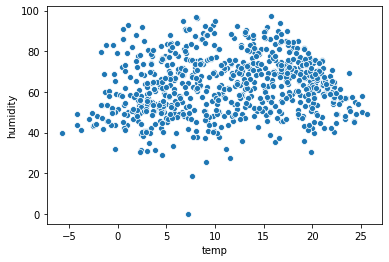

In [13]:
sns.scatterplot('temp', 'humidity', data=data)

In [14]:
X.columns

Index(['year', 'temp', 'feel_temp', 'humidity', 'windspeed', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter', 'holiday_no',
       'holiday_yes', 'weekday_friday', 'weekday_monday', 'weekday_saturday',
       'weekday_sunday', 'weekday_thursday', 'weekday_tuesday',
       'weekday_wednesday', 'workingday_no', 'workingday_yes', 'weather_clear',
       'weather_light rain', 'weather_mist'],
      dtype='object')

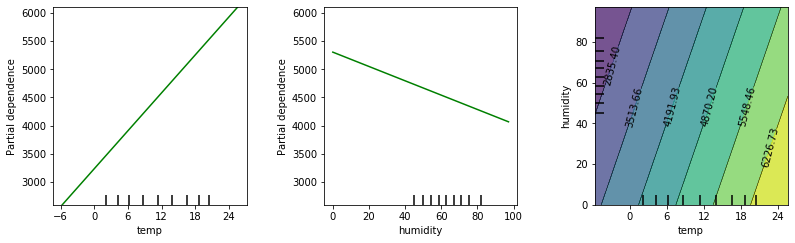

In [15]:
# small vertical lines are the data's deciles

fig, ax = plt.subplots(1, 3, figsize=(12,5))

plot_partial_dependence(lm_mod, X, features=[1, 3, (1, 3)],
                       grid_resolution=25, percentiles=(0, 1), n_jobs=4,
                       feature_names=X.columns, fig=fig)

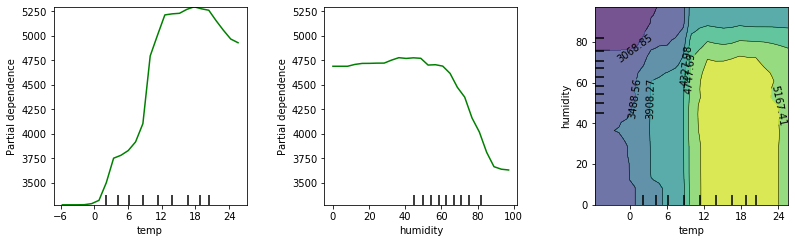

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))


plot_partial_dependence(rf_mod, X, features=[1, 3, (1, 3)],
                       grid_resolution=25, percentiles=(0, 1), n_jobs=4,
                       feature_names=X.columns, fig=fig)

### Problem 2: Understanding

PDPs solve this problem because TODO

# Shapley Values
# NOTE/TODO: the shap package implements SHAP, a newer method based on Shapley Values

https://github.com/slundberg/shap

- A bit more complex to compute
- Sampling
  - Draw a random sample from train/test data
- Intervention
  - TODO cf Scholbeck paper flowchart
- Prediction
  - Predict with intervened data
- Aggregation
  - TODO cf Scholbeck paper flowchart

In [17]:
import shap

In [18]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(rf_mod)

In [19]:
X_sub = X.sample(100, random_state=20190818)

In [20]:
shap_values = explainer.shap_values(X_sub)  # takes long

In [21]:
# load JS visualization code to notebook
shap.initjs()

In [22]:
i = 20
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[i,:], X_sub.iloc[i,:])

In [23]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_sub)

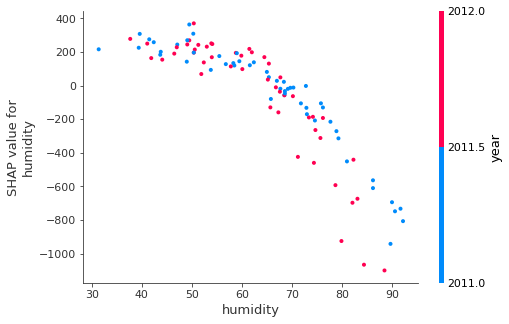

In [24]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("humidity", shap_values, X_sub)

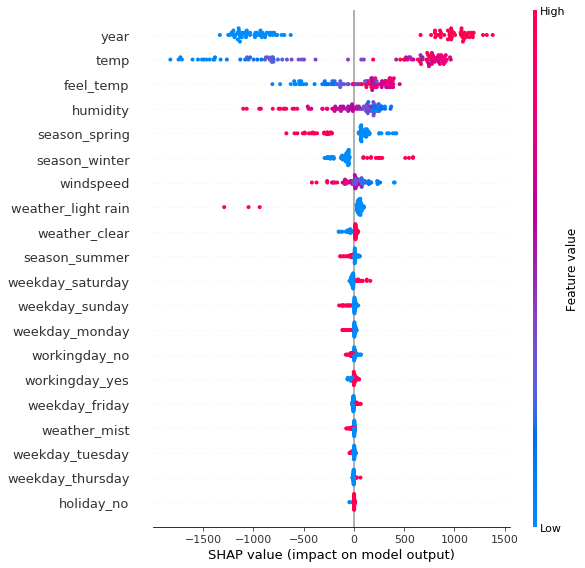

In [25]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sub)

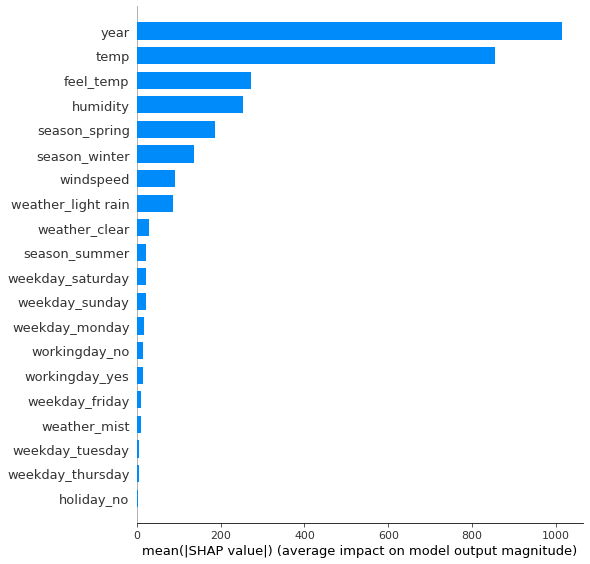

In [26]:
shap.summary_plot(shap_values, X_sub, plot_type="bar")

### Problem 3: Explainability

- Shapley Values or SHAP or LIME or Counterfactual Examples TODO solve this problem because TODO


# Topics not covered

- Global models
  - ALEs, because PDPs suffer when features are correlated
- Local, i.e. example-based methods
  - Counterfactual Explanations
	 - We tend to think in counterfactual cases. If we apply for a loan and get rejected, the best explanation for a human would be something like "if you earned 10'000€ more AND if you had paid that electricity bill in 2010, you'd been low-risk" (Molnar pg. 36-37)
	 - A counterfactual explanation is the "smallest change" to the feature values that changes the prediction to a predefined output (Molnar pg. 241)
  - Adversarial Expamples
     - TODO lightning talk?
	 - An adversarial example is an (artificial) instance with small changes in the features, that trick the model into making a false prediction.
	 - https://christophm.github.io/interpretable-ml-book/images/adversarial-turtle.jpg
	   - This turtle looks like a rifle from many angles and zoom levels.
       - It's not a big leap now to design a rifle that gets classified as a turtle.
	 - Adversarial examples make the ML model vulnerable to attacks. If you know them, you can use them in an updated training set. If your opponent knows them, he can get a loan, pass your gun detection AI, or make your car run over a stop sign (there are stickers for that)

----

- Refer to Molnar 2019 for everything

# The Future of Interpretable Machine Learning

- ML will grow because it *automatizes* decision making, and everyone likes automatization
- IML helps through:
	 - Hesitant adaptors that want predictions explained and demand some transparency (also due to legal reasons)
     - We need IML because we are never able to perfectly specify our goal to the computer. He stupidly does *exactly* what we tell him to. (Molnar pg 296). You specify an imperfect or a proxy goal (e.g. corporation: maximize profit for shareholders), and the "system" (e.g. model) might find a solution you didn't want (e.g. through imperfect training data).
- IML can be used to reverse engineer or game a model. Credit score models are better left uninterpreted (for the public), because people that still stay a risky debtor can just give back two credit cards to increase their score. This works for features that have a correlation influence (not causation influence) on the target. *Causal* features are not gameable. (pg. 25 Molnar)
- It's a relatively new field of research. Things change, papers come at high speed.
  - Theory and nomenclature is not yet unified.
    - One step forward: The SIPA paper
    - Many interpretation methods operate with the same workflow.
    - Scholbeck et al. (2019) summarized it into *the SIPA framework*
       - Sampling
         - You'll be predicting /a lot/. If the prediction function takes too long, use just a sample of your data
       - Intervention
         - Change some feature values in input data
         - Memorable metaphor: Permuted instances as "Frankenstein's Monster" (Molnar pg 231)
       - Prediction
         - Predict y using the intervened data
       - Aggregation
         - E.g. average local predictions (ICEs) to global ones (PDs)
- Adversarial Machine Learning is a new field in Cybersecurity. More ML models deployed IRL, more entry points for attacks. (Biggio++ 2018)
	- Use IML to understand the weaknesses in your models. Be one step ahead of your competition.
- Model-agnostic methods will grow because of aforementioned flexibility.
- Like ML, IML will be automatized in the future (molnar pg 299). Like a test suite that runs after every code build, every retrained model gets an automatic report of feature importance, PDPs, a few surrogate models, etc.
- We won't die out, though. Today anyone can build websites without HTML, CSS, JS, but we still need web developers. Tomorrow, anyone can train a ML model, but we'll still need ML experts. (molnar pg 300)

![end](img/end.jpg)

- <img src="img/twitter.svg" style="height: 20px; float: left" /> &nbsp; @eng_elhardt
- <img src="img/github.svg" style="height: 20px; float: left" /> &nbsp; AlexEngelhardt (slides: https://github.com/AlexEngelhardt/iml-talk)
- Longer blog post available at https://www.alpha-epsilon.de/blog/

# References

   - Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable", 2019. https://christophm.github.io/interpretable-ml-book/.
   - Scholbeck CA, Molnar C, Heumann C, Bischl B, Casalicchio G (2019). Sampling, Intervention, Prediction, Aggregation: A Generalized Framework for Model Agnostic Interpretations. https://arxiv.org/abs/1904.03959
   - Doshi-Velez, Finale, and Been Kim. “Towards a rigorous science of interpretable machine learning,” no. Ml: 1–13. http://arxiv.org/abs/1702.08608 (2017).
   - Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Model-agnostic interpretability of machine learning." https://arxiv.org/pdf/1606.05386 (2016).
   - Biggio, Battista, and Fabio Roli. "Wild patterns: Ten years after the rise of adversarial machine learning." Pattern Recognition 84 (2018): 317-331. https://arxiv.org/pdf/1712.03141

# Bonus Slides

### IML on training or test data?

- Molnar pg. 194 (online: chap 5.5.2)
- tl;dr: It depends on what you want to know
- Imagine an overfitted SVM with 100 garbage features.
  - What feature importance would you expect? 
    - Zero because the features are noise? $\Rightarrow$ use test data
    - Or should they reflect how much the model depends on each feature? $\Rightarrow$ use training data

# Bonus Slides

### Correlations in features

- If features are correlated, partial dependence plots will be computed with unrealistic instances
- e.g. `temp = 20` degrees, but `feel_temp = -5`

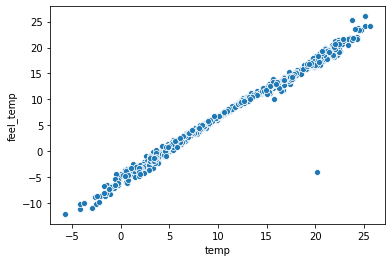

In [27]:
sns.scatterplot('temp', 'feel_temp', data=data)

- wat do?
- A method called *Accumulated Local Effects* (ALEs) is unbiased then
- See Molnar 2019